# Машинное обучение, DS-поток, осень 2022
# Задание 3.8. Модели градиентного бустинга

## Теория

### Задача 1

В модели XGBoost запишите задачу оптимизации при построении нового дерева, критерий информативности и оптимальные ответы в листьях в следующих случаях.
1. Задача регрессии, квадратичная функция потерь $L(y, z) = (y - z)^2$.
2. Задача классификации, экспоненциальная функция потерь $L(y, z) = e^{-yz}$.
3. Задача классификации, логистическая функция потерь $L(y, z) = \ln(1 + e^{-yz})$.

В задачах классификации классификатор предсказывает степень уверенности принадлежности классу из $\mathscr{Y} \in \{-1, +1\}$. Решающее правило имеет вид $f(x) = \mathrm{sign} \widehat{y}(x)$.

## Практика

### Задача 2

В файле `houses_train.csv` представлен набор данных про квартиры в городе Сиэтл, штат Вашингтон. Задача — предсказать цену на жилье по имеющимся данным.

Данные имеют следующие столбцы:
* `id` — идентификационный номер жилья
* `date` — дата продажи дома
* `price` — цена
* `bedrooms` — количество спален
* `bathrooms` — количество ванных комнат, где .5 означает комнату с туалетом, но без душа
* `sqft_living` — площадь жилья
* `sqft_lot` — площадь участка
* `floors` — количество этажей
* `waterfront` — видна ли набережная
* `view` — насколько хороший вид
* `condition` — индекс от 1 от 5, отвечающий за состояние квартиры
* `grade` — 1 до 13, 1-3 соответствует плохому уровню строительства и дизайна, 3-7 — средний уровень, 11-13 — высокий.
* `sqft_above` — жилая площадь над уровнем земли
* `sqft_basement` — жилая площадь под уровнем земли
* `yr_built` — год постройки жилья
* `yr_renovated` — год последней реконструкции жилья
* `zipcode` — почтовый индекс
* `lat` — широта
* `long` — долгота
* `sqft_living15` — средняя площадь жилья ближайших 15-и соседей
* `sqft_lot15` — средняя площадь участка ближайших 15-и соседей

Исследуйте зависимость качества по метрике MAPE для моделей XGBoost, LightGBM, CatBoost, а так же градиентного бустинга из sklearn, в зависимости от количества деревьев, их максимальной глубины, шага обучения, l1 и l2 регуляризаций. При исследовании одного гиперпараметра рисуйте один график для всех моделей. Тщательно подберите цвета и тип линий, масштаб осей так, чтобы картинка была легко читаемой. При проведении исследований не забывайте писать подробные комментариии и выводы.

*Советы.*
* Используйте код с семинаров.
* Пока мы не умеем работать с признаком `zipcode`, удалите его из данных.

*Замечания.*
* Не забывайте, что для некоторых параметров стоит генерировать сетку значений при помощи `np.logspace`.

In [ ]:
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix, mean_squared_error, mean_absolute_percentage_error
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('./houses_train.csv')
data.drop('zipcode', axis=1, inplace=True)
data.head()

*Также для анализа  не нужен признак `id` - не влияет на цену*

In [ ]:
data.drop(['id'], axis=1, inplace=True)

*Проверим на пропуски*

In [ ]:
data.isna().any()

*Пропусков нет*

### Решение Задачи 2

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data.drop(columns=['price']), data['price'], test_size=0.3, random_state=42
)

In [ ]:
X_train.drop(['date'], axis=1, inplace=True)
X_valid.drop(['date'], axis=1, inplace=True)

In [ ]:
colors = ['#FF3300', '#0099CC', '#00CC66', 'orange']

def plot_dependence_test(param_grid, mape_train, mape_valid, descr,
                         param_label, title, log_x_scale=False, ylim=(0.1, 0.2)):
    '''
    Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра моделей на обучающей и валидационной выборках.
    '''
    
    plt.figure(figsize=(10, 6))
    
    for i in range(len(mape_train)):
        plt.plot(param_grid, mape_train[i], color=colors[i], 
                 linewidth=1, alpha=0.7, linestyle='--',
                 label=f'{descr[i]} train')
        plt.plot(param_grid, mape_valid[i], color=colors[i], 
                 linewidth=2, alpha=0.7, 
                 label=f'{descr[i]} valid')
   
    plt.xlabel(param_label)
    plt.ylabel('MAPE, %')
    plt.legend(ncol=2)
    plt.title(title)
    if log_x_scale:
        plt.xscale('log')
    plt.ylim(ylim)

In [ ]:
n_estimators_grid = np.arange(1, 1000)

# XGBoost
regressor = XGBRegressor(n_estimators=max(n_estimators_grid))
regressor.fit(X_train, y_train)
mape_train = [[mean_absolute_percentage_error(y_train, regressor.predict(X_train, ntree_limit=i+1))
                for i in range(max(n_estimators_grid))]]
mape_valid = [[mean_absolute_percentage_error(y_valid, regressor.predict(X_valid, ntree_limit=i+1))
                for i in range(max(n_estimators_grid))]]

# LightGBM
regressor = LGBMRegressor(n_estimators=max(n_estimators_grid))
regressor.fit(X_train, y_train)
mape_train += [[mean_absolute_percentage_error(y_train, regressor.predict(X_train, 
                                                num_iteration=i+1))
                for i in range(max(n_estimators_grid))]]
mape_valid += [[mean_absolute_percentage_error(y_valid, regressor.predict(X_valid, 
                                                num_iteration=i+1))
                for i in range(max(n_estimators_grid))]]

# CatBoost
regressor = CatBoostRegressor(n_estimators=max(n_estimators_grid), silent=True)
regressor.fit(X_train, y_train)
mape_train += [[mean_absolute_percentage_error(y_train, regressor.predict(X_train, ntree_end=i+1))
                for i in range(max(n_estimators_grid))]]
mape_valid += [[mean_absolute_percentage_error(y_valid, regressor.predict(X_valid, ntree_end=i+1))
                for i in range(max(n_estimators_grid))]]

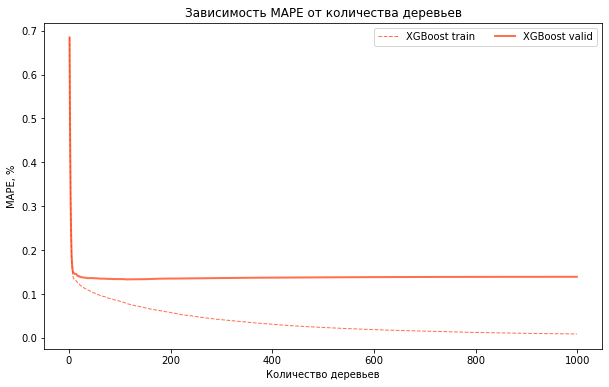

In [12]:
plot_dependence_test(
    param_grid=n_estimators_grid, 
    mape_train=mape_train, 
    mape_valid=mape_valid,
    descr=['XGBoost', 'LGBM', 'CatBoost'],
    param_label='Количество деревьев', 
    title='Зависимость MAPE от количества деревьев',
    ylim=None
)

### Решение Задачи 3

## *1. Визуальный анализ признаков и предобработка*

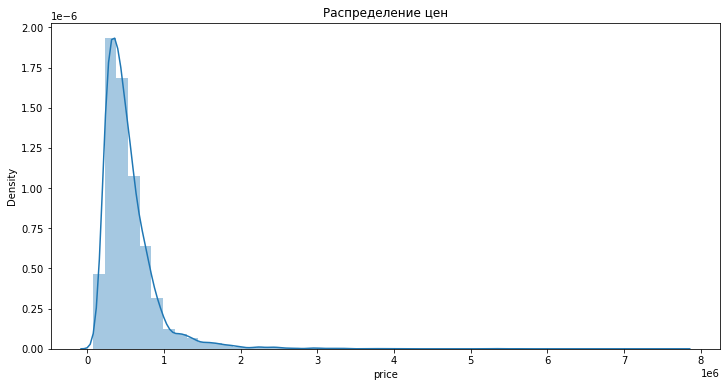

In [7]:
plt.figure(figsize=(12, 6))
sns.distplot(data['price'])
plt.title('Распределение цен');

*Распределение цен не совсем нормальное - есть длинный хвост*

*Посмотрим на зависимость таргета с признаками. Сначала посмотрим 10 наиболее линейно-зависимых*

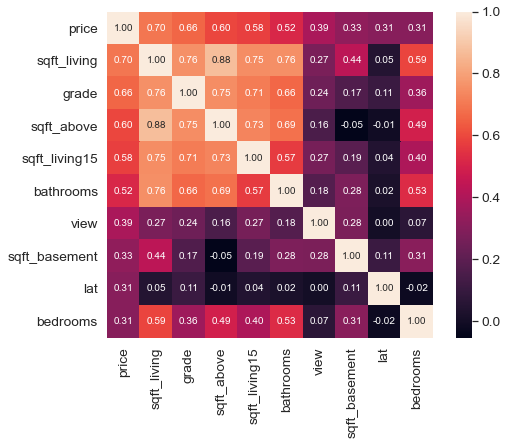

In [8]:
plt.figure(figsize=(8, 6))
corrmat = data.corr()
cols = corrmat.nlargest(10, 'price')['price'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)

- Цена больше всего зависит от `sqft_living` и остальных признаков площади и `grade` - качества строительства и дизайна
- Сильно коррелируют между собой признаки `sqft_living` и `sqft_above`. По сути, это один и тот же признак, так как в большинстве жилая площадь - это площадь без подвала. Также сильно коррелируют `sqft_living` и `sqft_living15` - видимо потому что ближайшие дома в нейборхуде примерно одинаковые
- Cильно коррелируют `sqft_living` и `bathrooms`, ожидаемо.


*Надо избавляться от линейно-зависимых признаков*

In [9]:
(data['sqft_living'] == data['sqft_above'] + data['sqft_basement']).sum() / data.shape[0]

0.9610904902086267

*В 96% случаев жилая площадь = площадь надземной и подземной части дома. Значит можно избавиться от последних 2х признаков.*

In [10]:
data.drop(['sqft_above', 'sqft_basement'], axis=1, inplace=True)

*Также сильно зависят между собой размер дома и участка с размерами соседей. Эти признаки не будем брать для анализа*

In [11]:
data.drop(['sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

*Посмотрим отдельно на некоторые категориальные признаки*

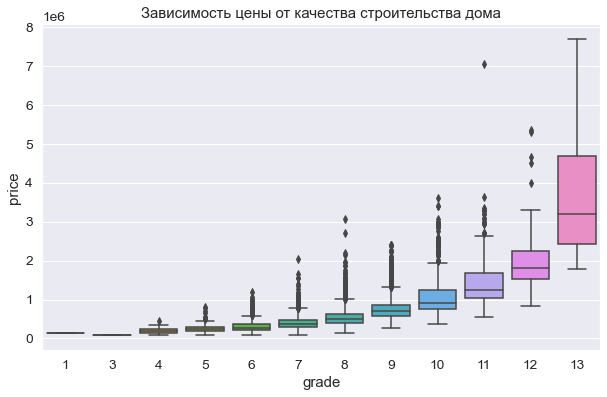

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='price', data=data)
plt.title('Зависимость цены от качества строительства дома');

*Кроме прямой зависимости, так же видно что есть выбросы*

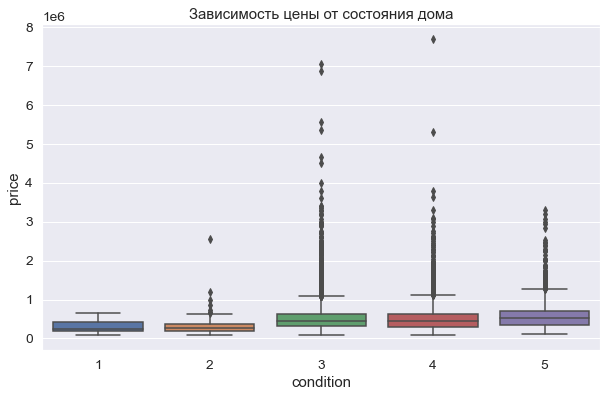

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='price', data=data)
plt.title('Зависимость цены от состояния дома');

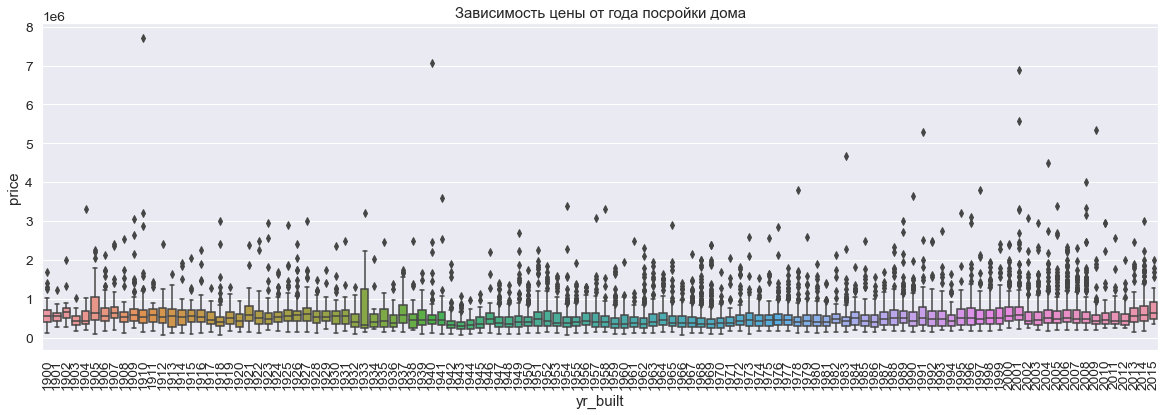

In [14]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='yr_built', y='price', data=data)
plt.title('Зависимость цены от года посройки дома')
plt.xticks(rotation=90);

*Так же не видно особого влияния года постройки на цену.*

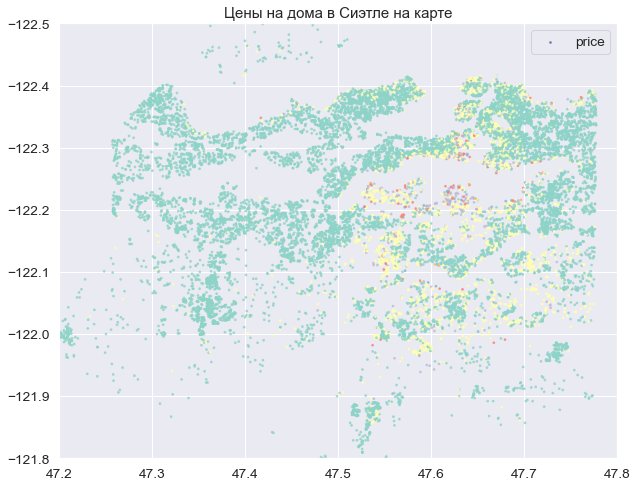

In [15]:
plt.figure(figsize=(10, 8))
plt.scatter(data.lat, data.long, s=3, c=data.price, cmap='Set3', alpha=0.7, label='price')
plt.ylim((-121.8, -122.5))
plt.xlim((47.2, 47.8))
plt.legend()
plt.title('Цены на дома в Cиэтле на карте');

*Какая-то зависимость от расположения есть - более "центральные" дома дороже.*

### *Выбросы*

*Особенность в категориальных признаках - слишком много значений, которые считаются выбросами в предположении, что они распределены нормально. Но они в реальности не распредлелены нормально и убирать всe данные которые за 75-процентилью нельзя. Буду считать выбросами значения за 95-процентилью*

*Убираю выбросы по ценам так, чтобы не нарушалось распределение самых качественных домов (grade = max)*

In [16]:
data = data[data['price'] < 4e6]

*Далее убираю выбросы по отдельным признакам*

In [17]:
(data.bedrooms > 6).sum() / data.shape[0]

0.0027534097457898444

In [18]:
data = data[data.bedrooms <= 6]

In [19]:
(data.bathrooms > 5).sum() / data.shape[0]

0.0010273532811095416

In [20]:
data = data[(data.bathrooms <= 5) & (data.bathrooms > 0)]

### *Feature generation*

*Превратим реновацию в категориальный признак*

In [21]:
data['renovated'] = data['yr_renovated'].apply(lambda x : 0 if x == 0 else 1)
data.drop(['yr_renovated'], axis=1, inplace=True)

*Из даты продажи оставим только год*

In [22]:
data['date'] = data.loc[:, 'date'].apply(lambda d: int(d[:4]))

In [23]:
data['yr_built'] = data.loc[:, 'yr_built'].apply(lambda d: int(d))

*Переведем `bathrooms`, `floors` в категориальные, так как у них конечное число вариантов, а значения - вещественные. Для простоты будем считать 0.5 за отдельные ванну или этаж*

In [24]:
data['bathrooms'] = data.loc[:, 'bathrooms'].apply(lambda n: int(round(n)))

In [25]:
data['floors'] = data.loc[:, 'floors'].apply(lambda n: int(round(n)))

*Итоговый датасет*

In [26]:
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,lat,long,renovated
0,2015,221900.0,3,1,1180,5650,1,0,0,3,7,1955,47.5112,-122.257,0
1,2015,538000.0,3,2,2570,7242,2,0,0,3,7,1951,47.7210,-122.319,1
2,2015,604000.0,4,3,1960,5000,1,0,0,5,7,1965,47.5208,-122.393,0
3,2016,510000.0,3,2,1680,8080,1,0,0,3,8,1987,47.6168,-122.045,0
4,2015,257500.0,3,2,1715,6819,2,0,0,3,7,1995,47.3097,-122.327,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,2016,429000.0,3,2,1490,1126,3,0,0,3,8,2014,47.5699,-122.288,0
15622,2015,610685.0,4,2,2520,6023,2,0,0,3,9,2014,47.5137,-122.167,0
15623,2015,360000.0,3,2,1530,1131,3,0,0,3,8,2009,47.6993,-122.346,0
15624,2016,400000.0,4,2,2310,5813,2,0,0,3,8,2014,47.5107,-122.362,0


## *2. Бустинг*

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price'], axis=1, inplace=False), 
    data['price'], test_size=0.2, shuffle=True, random_state=17
)

### *XGBoost*

In [29]:
xgtrain = xgb.DMatrix(X_train.values, y_train.values)
xgtest = xgb.DMatrix(X_test.values, y_test.values)
evallist = [(xgtest, 'eval'), (xgtrain, 'train')]

In [30]:
xgb_params = {
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'eval_metric': 'mape'
}

In [31]:
cvresult = xgb.cv(
    xgb_params, xgtrain, num_boost_round=3000, 
    nfold=5, early_stopping_rounds=300
)

In [32]:
cvresult[-3:]

,train-mape-mean,train-mape-std,test-mape-mean,test-mape-std
465,0.084412,0.000343,0.126244,0.001127
466,0.084344,0.000344,0.126242,0.001104
467,0.084277,0.000341,0.126234,0.001104


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(cvresult.index, cvresult['train-mape-mean']*100)
plt.title('Зависимость MAPE от количества базовых моделей');

Обучение остановилось на 467 деревьях, зафиксируем.

In [34]:
n_estimators = 467

In [35]:
param_grid = {
    'max_depth': range(3, 10),
    'min_child_weight': range(1, 10),
}

xgb_params = {
    'booster': 'gbtree',
    'n_estimators': n_estimators,
    'learning_rate': 0.1,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'eval_metric': 'mape'
}

In [38]:
gs = GridSearchCV(xgb.XGBRegressor(**xgb_params), param_grid, n_jobs=-1, 
                  scoring='neg_mean_absolute_percentage_error', verbose=1, cv=5)

In [39]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='mape', gamma=0.1, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bin=None,
                                    max_...p=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=467,
                                    n_jobs=None, num_parallel_t

In [40]:
gs.best_params_

{'max_depth': 6, 'min_child_weight': 4}

In [41]:
param_grid1 = {
    'gamma': [i / 10 for i in range(5)]
}

xgb_params_1 = {
    'booster': 'gbtree',
    'n_estimators': n_estimators,
    'learning_rate': 0.1,
    'max_depth': gs.best_params_['max_depth'],
    'min_child_weight': gs.best_params_['min_child_weight'],
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'eval_metric': 'mape'
}

In [42]:
gs1 = GridSearchCV(xgb.XGBRegressor(**xgb_params_1), param_grid1, 
                  n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1, cv=5)

In [43]:
gs1.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='mape', gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=6, max_leaves=None,
                                    min_child_weight=4, missing=nan,
                                    monotone_constraints=None, n_estimators=467,
                                    n_

In [44]:
gs1.best_params_

{'gamma': 0.0}

In [45]:
param_grid2 = {
    'subsample': [i / 10 for i in range(4, 11)],
    'colsample_bytree': [i / 10 for i in range(4, 11)]
}

xgb_params2 = {
    'booster': 'gbtree',
    'n_estimators': n_estimators,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 4,
    'gamma': 0.0,
    'random_state': 42,
    'eval_metric': 'mape'
}

In [46]:
gs2 = GridSearchCV(xgb.XGBRegressor(**xgb_params2), param_grid2,  n_jobs=-1, 
                  scoring='neg_mean_absolute_percentage_error', verbose=1, cv=5)

In [47]:
gs2.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='mape', gamma=0.0, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bin=None,
                                    max...
                                    max_depth=6, max_leaves=None,
                                    min_child_weight=4, missing=nan,
                                    monotone_constraints=None, n_estimators=467,
                                    n_jo

In [48]:
gs2.best_params_

{'colsample_bytree': 0.8, 'subsample': 0.8}

In [49]:
param_grid3 = {
    'alpha': np.logspace(-6, 1, 10),
    'lambda': np.logspace(-6, 1, 10),
}

xgb_params3 = {
    'booster': 'gbtree',
    'n_estimators': n_estimators,
    'learning_rate': 0.1,
    'max_depth': 6,
    'gamma': 0,
    'min_child_weight': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'eval_metric': 'mape'
}

In [50]:
gs3 = GridSearchCV(xgb.XGBRegressor(**xgb_params3), param_grid3,  n_jobs=-1, 
                  scoring='neg_mean_absolute_percentage_error', verbose=1, cv=5)

In [51]:
gs3.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='mape', gamma=0, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bin=None,
                                    max_ca...
             param_grid={'alpha': array([1.00000000e-06, 5.99484250e-06, 3.59381366e-05, 2.15443469e-04,
       1.29154967e-03, 7.74263683e-03, 4.64158883e-02, 2.78255940e-01,
       1.66810054e+00, 1.00000000e+01]),
                         'lambda': array([1.00000000e-06, 5.99484250e-06, 3

In [52]:
gs3.best_estimator_

XGBRegressor(alpha=0.2782559402207126, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mape', gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', lambda=10.0, learning_rate=0.1,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
             max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=467, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [ ]:
res3 = pd.DataFrame(gs3.cv_results_)

In [ ]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(res3['param_alpha'], res3['param_lambda'], res3['mean_test_score']) 
plt.title('Зависимость -MAPE от параметров регуляризации');

In [55]:
gs3.best_params_

{'alpha': 0.2782559402207126, 'lambda': 10.0}

In [56]:
mean_absolute_percentage_error(gs.best_estimator_.predict(X_test), y_test)

0.11774373692306593

In [ ]:
test_df = pd.read_csv('./houses_test.csv')
test_df.drop(['id', 'zipcode', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

test_df['renovated'] = test_df['yr_renovated'].apply(lambda x : 0 if x == 0 else 1)
test_df.drop(['yr_renovated'], axis=1, inplace=True)
test_df['date'] = test_df.loc[:, 'date'].apply(lambda d: int(d[:4]))
test_df['yr_built'] = test_df.loc[:, 'yr_built'].apply(lambda d: int(d))
test_df['bathrooms'] = test_df.loc[:, 'bathrooms'].apply(lambda n: int(round(n)))
test_df['floors'] = test_df.loc[:, 'floors'].apply(lambda n: int(round(n)))

In [ ]:
results = gs.best_estimator_.predict(test_df)

In [ ]:
results_df = pd.DataFrame(results, columns=['price'])
results_df.index.name = 'index'
results_df.index += 1 
results_df.to_csv('results.csv')
results_df

### Задача 3

В продолжении исследований из предыдущей задачи выберите некоторое количество хороших на ваш взгляд моделей, постройте для них предсказание на тестовой выборке. Полученные предсказания отправьте в тренировочное соревнование на Kaggle.

Ссылка: https://www.kaggle.com/competitions/ds-2022-autumn/overview

Инвайт: https://www.kaggle.com/t/cc114f8334c54504997045ddd6036313

**Правила**

* В Kaggle в данное тренировочное соревнование можно отправлять не более 7 решений в день (8-ю система не позволит).
* Решения индивидуальные.
* Качество считается по метрике MAPE.
* До окончания соревнования доступны значения качества, посчитанные только на случайных 30% тестовых данных. Значения отображаются в Public Leaderboard
* После окончания соревнования становится доступным Private Leaderboard, в котором значения качества посчитанны на оставшихся 70% объектов.
* Для включения в Private Leaderboard можно выбрать две посылки.
* В Leaderboard должны отображаться ваши реальные имя и фамилия. В противном случае решение может быть не зачтено.
* Все файлы, которые вы отправляете в соревнование, видны организаторам соревнования. Файлы должны иметь понятное имя, при отправке файла в систему необходимо написать краткое описание решения.
* В решении, отправляемом боту, должно быть отображено, результаты каких моделей вы отправляете в соревнование.
* Пользоваться можно любыми пройденными в наших курсах моделями.
* Код студентов, занявших первые 3 места, будет запускаться. Также выборочно может запускаться код и остальных студентов
* Не забывайте сделать пояснения к своему решению.

**Советы**

* Чтобы получить действительно хороший результат подбора гиперпараметров мало, попробуйте ввести новые признаки для улучшения качества решения.
* Некоторые инсайты по тому, какие признаки могут улучшить качество, можно получить если провести разведывательный анализ данных (EDA). Например, может иметь смысл изучить датасет на предмет наличия выбросов, исследовать пространственное и временное распределение отклика. 

**Бонусы**

* Выдаются только при соблюдении всех правил и суммируются.
* 10 баллов — ваше решение лучше sample_submission.csv на Private Leaderboard.
* 10 баллов — ваше решение имеет ошибку не более 12.3% по метрике MAPE на Private Leaderboard.
* 1 конфета — попадание в топ-10 на Private Leaderboard.
* 1 средняя конфета — попадание в топ-3 на Private Leaderboard.
* 1 большая конфета — попадание в топ-1 на Private Leaderboard.